In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import tensorflow as tf

# Import necessary layers for building the neural network
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
# Import the Sequential model API for creating a linear stack of layers
from tensorflow.keras.models import Sequential
# Import optimizers for updating the model's weights during training
from tensorflow.keras.optimizers import SGD, Adam
# Import callbacks for training behavior control
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [37]:
data_ = pd.read_csv('RELIANCE.NS.csv', index_col='Date', parse_dates=['Date'])

# pd.read_csv(...): This line uses the read_csv function from the pandas library (imported as pd) to read data from a CSV (Comma-Separated Values) file.
# /content/drive/MyDrive/Colab Notebooks/TimesPro/RELIANCE.NS.csv: This is the file path specifying the location of the CSV file containing the data.
# index_col='Date': This argument sets the 'Date' column as the index (row labels) of the resulting DataFrame.
# parse_dates=['Date']: This tells pandas to interpret the 'Date' column as dates, making it easier to work with time-series data.
# data_: The data read from the CSV file is stored in a pandas DataFrame named data_. A DataFrame is a table-like data structure, like a spreadsheet.

row_with_nan = data_[data_.isnull().any(axis=1)].iloc[0]
print(row_with_nan)


print(f"Dataset shape before dropping NAN value rows: {data_.shape}")

data = data_.dropna(inplace=False)   #returns a new data frame

# data = data_.dropna(inplace=False): This is a crucial step where rows containing "Not a Number" (NaN) values are removed.
# dropna() is a pandas function that drops rows or columns with missing values.
# inplace=False means that the original data_ DataFrame is not modified. Instead, a new DataFrame named data is created without the NaN values.

print(f"Dataset shape after dropping NAN value rows: {data.shape}")

Open        NaN
High        NaN
Low         NaN
Close       NaN
Adj Close   NaN
Volume      NaN
Name: 1996-01-26 00:00:00, dtype: float64
Dataset shape before dropping NAN value rows: (6291, 6)
Dataset shape after dropping NAN value rows: (6164, 6)


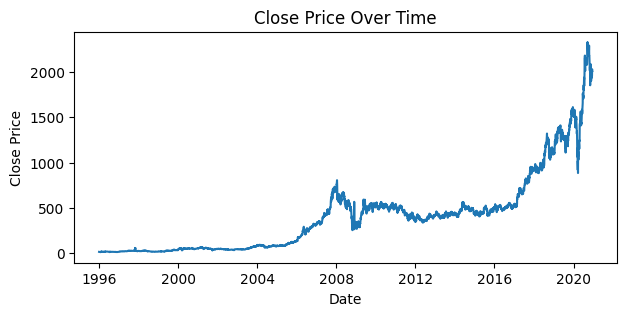

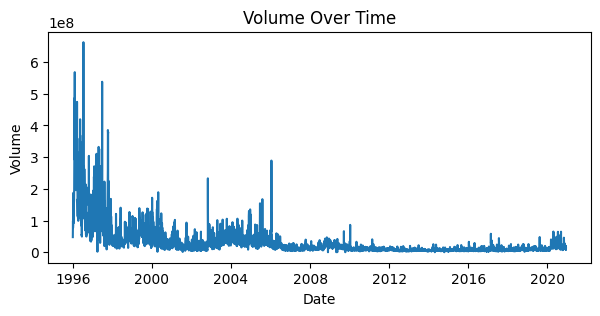

In [38]:
# Visualize the data using a line plot
plt.figure(figsize=(7, 3))
plt.plot(data['Close'])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# You can also visualize other columns like Open, High, Low, Volume
# Example for Volume:
plt.figure(figsize=(7, 3))
plt.plot(data['Volume'])
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [39]:
# Select input features for the model (Open, High, and Volume)
# The input features are chosen based on their potential relevance to predicting stock prices
# each sequence element will contain the 'Open', 'High', and 'Volume' values for the past 60 days

input_data = data[['Open', 'High', 'Volume']]

# Print the column names of the input features
print(input_data.keys())

# Extract the 'Close' prices as the output data
# The output data will be used to train the model to predict future stock prices
# The 'Close' prices are the target variable for the model

output_data = data[['Close']].values

# Initialize separate scalers for input and output features
# Separate scalers are used to normalize input features and output data independently

input_scaler = MinMaxScaler(feature_range=(0, 1))
output_scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the input features to a range between 0 and 1
scaled_data = input_scaler.fit_transform(input_data)

# Normalize the output (Close prices) separately
scaled_output = output_scaler.fit_transform(output_data)

Index(['Open', 'High', 'Volume'], dtype='object')


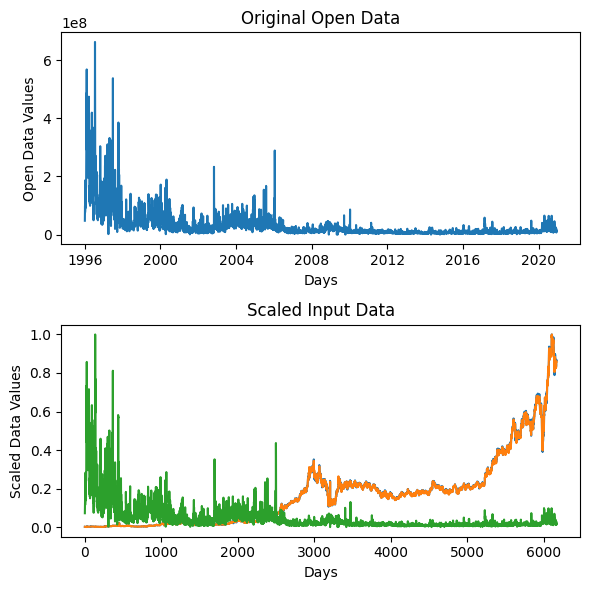

In [40]:
plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(input_data['Volume'])
plt.title('Original Open Data')
plt.xlabel('Days')
plt.ylabel('Open Data Values')

plt.subplot(2, 1, 2)
plt.plot(scaled_data)
plt.title('Scaled Input Data')
plt.xlabel('Days')
plt.ylabel('Scaled Data Values')

plt.tight_layout()
plt.show()

In [41]:
# Define the percentage of data to use for training
training_data_len = int(np.ceil(len(scaled_data) * 0.70))

# Split the data into training and test sets
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len:, :]

# Initialize lists to store sequences for training and testing
x_train, x_test, y_train, y_test, y_test_org = [], [], [], [], []
seq_length = 60  # Number of time steps to look back

# Create sequences for training data
# This loop iterates over the training data to create sequences of 60 time steps for input and the next 5 time steps as output
# This is done to predict the next 5 closing prices based on the previous 60 days of data
# 
for i in range(len(train_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_train.append(train_data[i:(i + seq_length)])
    # Append the next 5 time steps as output for prediction (since we want to predict 5 future close prices)
    y_train.append(scaled_output[(i + seq_length):(i + seq_length + 5)])

# Create sequences for test data
for i in range(len(test_data) - seq_length - 4):
    # Append sequences of 60 time steps for input
    x_test.append(test_data[i:(i + seq_length)])
    # Append the next 5 time steps as scaled output for prediction
    y_test.append(scaled_output[training_data_len + i + seq_length:
                                training_data_len + i + seq_length + 5])
    # Append the next 5 time steps as original output for comparison
    y_test_org.append(output_data[training_data_len + i + seq_length:
                                  training_data_len + i + seq_length + 5])

# Convert lists to numpy arrays for model input
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
y_test_org = np.array(y_test_org)

# Print shapes for verification
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
print("y_test_org shape:", y_test_org.shape)


x_train shape: (4251, 60, 3)
y_train shape: (4251, 5, 1)
x_test shape: (1785, 60, 3)
y_test shape: (1785, 5, 1)
y_test_org shape: (1785, 5, 1)


In [42]:
# Initialize a Sequential model - a linear stack of layers
model = Sequential()

# First LSTM Layer
model.add(LSTM(
    units=80,  # Number of LSTM units/neurons in this layer
    return_sequences=True,  # Return full sequence for next LSTM layer
    input_shape=(x_train.shape[1], 3)  # Input shape: (sequence_length, number_of_features)
    # sequence_length = 60 time steps
    # number_of_features = 3 (Open, High, Volume)
))

# Second LSTM Layer
model.add(LSTM(
    units=50,  # Number of LSTM units/neurons
    return_sequences=False  # Return only the last output (many-to-one architecture)
    # This is needed because we want to connect to a Dense layer next
))

# Output Dense Layer
model.add(Dense(
    units=5,  # Output 5 values (predicting next 5 time steps)
    activation='relu'  # ReLU activation for positive stock price predictions
))

# Display model architecture summary
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')



d:\Program Files\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 80)         │        26,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        26,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,335 (208.34 KB)

 Trainable params: 53,335 (208.34 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)



Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0015 - val_loss: 8.4609e-05 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 8.4322e-05 - val_loss: 7.8193e-05 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 7.8714e-05 - val_loss: 1.4362e-04 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.0207e-05 - val_loss: 6.4414e-05 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.9805e-05 - val_loss: 6.9530e-05 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.4725e-05 - val_loss: 6.1594e-05 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 5.4238e-05 - val_loss: 6.2620e-05 - learning_rate: 2.0000e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 5.5543e-05 - val_loss: 7.0478e-05 - learning_rate: 2.0000e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━

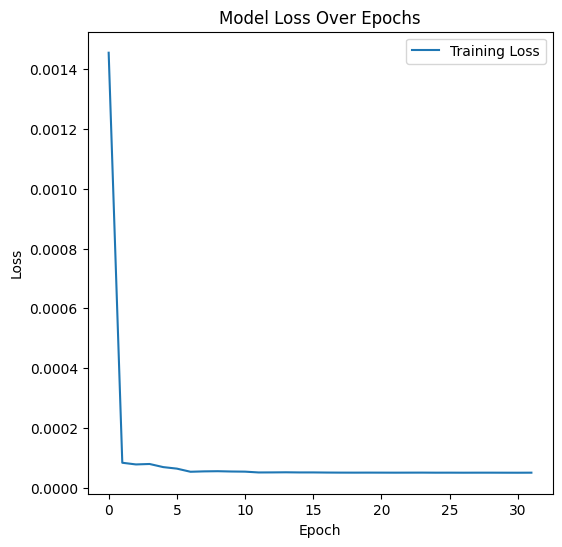

In [44]:
plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [45]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
(1785, 5)
(1785, 5, 1)
(1785, 5)
The root mean squared error is 144.67253662357524.


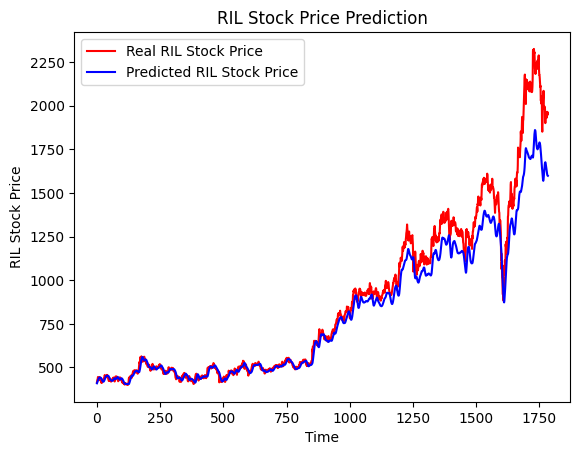

In [ ]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real RIL Stock Price')
    plt.plot(predicted, color='blue',label='Predicted RIL Stock Price')
    plt.title('RIL Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('RIL Stock Price')
    plt.legend()
    plt.show()
    
plot_predictions(y_test_org[:,0],predictions_org[:,0])

d:\Program Files\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 200)            │       163,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,205 (641.43 KB)

 Trainable params: 164,205 (641.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0012 - val_loss: 1.2367e-04 - learning_rate: 0.0010
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.7255e-04 - val_loss: 2.4767e-04 - learning_rate: 0.0010
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.4843e-04 - val_loss: 1.5202e-04 - learning_rate: 0.0010
Epoch 4/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1.3031e-04 - val_loss: 5.4463e-05 - learning_rate: 0.0010
Epoch 5/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 1.1555e-04 - val_loss: 6.7688e-05 - learning_rate: 0.0010
Epoch 6/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 1.0697e-04 - val_loss: 1.4385e-04 - learning_rate: 0.0010
Epoch 7/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 9.8801e-05 - val_loss: 4.9431e-05 - learning_rate: 2.0000e-04
Epoch 8/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 9.3497e-05 - val_loss: 4.7656e-05 - learning_rate: 2.0000e-04
Epoch 9/100
107/107 ━━━━━━━━━━━━━━━━

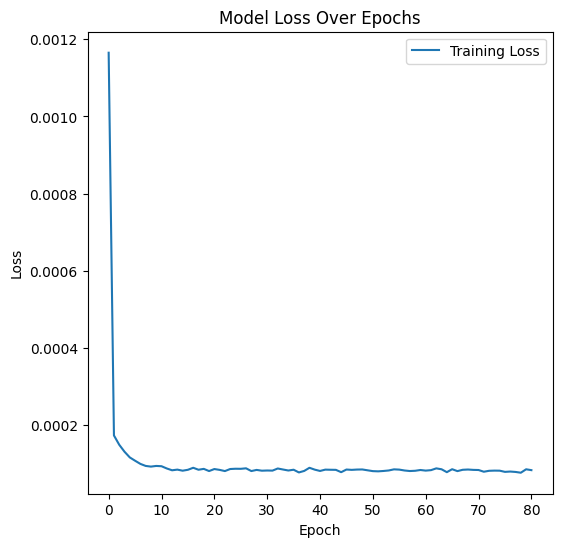

In [59]:
# Experimenting with a deeper LSTM model architecture of different configuration


model = Sequential()
model.add(LSTM(200, return_sequences=False, input_shape=(x_train.shape[1], 3)))
model.add(Dropout(0.3))
# model.add(LSTM(units=20, return_sequences=False))
# model.add(Dropout(0.3))
#model.add(Dense(units=20, activation='tanh'))
model.add(Dense(units=5, activation='relu'))
model.summary()


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stopping, reduce_lr], verbose=1)

plt.figure(figsize=(6, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss'], loc='upper right')
plt.show()

In [60]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

predictions_scaled = model.predict(x_test)
print(predictions_scaled.shape)
predictions_org = output_scaler.inverse_transform(predictions_scaled)


print(y_test_org.shape)
print(predictions_scaled.shape)
return_rmse(y_test_org[:,:,0],predictions_org)

56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
(1785, 5)
(1785, 5, 1)
(1785, 5)
The root mean squared error is 86.33510962164526.
